<a href="https://colab.research.google.com/github/alimomennasab/ASL-Translator/blob/main/CS4200_3DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data Preprocessing

In [ ]:
# if a label folder has under 5 videos, add to ignore list
import os

dataset_dir = "/content/drive/MyDrive/WLASL/WLASL100_train_augmented_60frames"
ignore_labels = []
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if len(os.listdir(label_dir)) < 5:
        ignore_labels.append(label)

print(f"Ignored labels: {sorted(ignore_labels)}")

# Ignored labels: []

Ignored labels: []


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


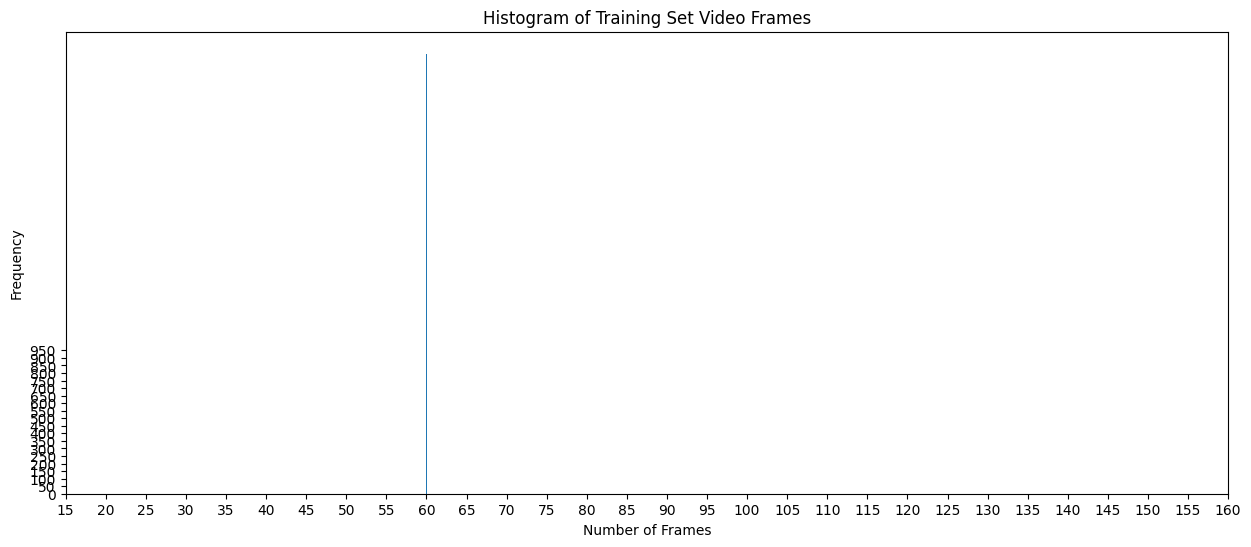

Average number of frames: 60.00
Minimum frame count: 60, video=56848_AUG1_mirror_bright_duplicated.mp4
Maximum frame count: 60, video=56848_AUG1_mirror_bright_duplicated.mp4


In [ ]:
# histogram of video frames

import cv2
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np

#vid_path = "/content/drive/MyDrive/WLASL/WLASL100_train_augmented/"
vid_path = "/content/drive/MyDrive/WLASL/WLASL100_train_augmented_60frames/"

frames = []
for folder in tqdm.tqdm(os.listdir(vid_path)):
  folder_path = os.path.join(vid_path, folder)
  for vid in os.listdir(folder_path):
    cap = cv2.VideoCapture(os.path.join(folder_path, vid))

    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        #print(f"Total number of frames: {total_frames}")
        frames.append((total_frames, vid))

        cap.release()

frame_counts = [f[0] for f in frames]

# Plot
plt.figure(figsize=(15, 6))
interval = 5
start = 15
end = 160
plt.hist(frame_counts, bins= int((end - start)//interval))
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.title('Histogram of Training Set Video Frames')
plt.xlim(start, end)
plt.xticks(np.arange(start, end+1, interval))
plt.yticks(np.arange(0, 1000, 50))

plt.show()

# Stats
avg_frames = sum(frame_counts) / len(frame_counts)
min_tuple = min(frames, key=lambda x: x[0])
max_tuple = max(frames, key=lambda x: x[0])
print(f"Average number of frames: {avg_frames:.2f}")
print(f"Minimum frame count: {min_tuple[0]}, video={min_tuple[1]}")
print(f"Maximum frame count: {max_tuple[0]}, video={max_tuple[1]}")

# Average number of frames: 63.07
# Minimum frame count: 19, video=06334_AUG1_zoom_fast.mp4
# Maximum frame count: 155, video=63232_AUG2_bright_mirror.mp4

Data Augmentation

In [7]:
# Go through a dataset and transform every video to have a target number of frames

import cv2
import os
import tqdm
import numpy as np

# duplicate frames in a video starting with the middle frames and expanding outwards until we reach a target frame count
def duplicate_frames(frames, target=60):
    n = len(frames)
    if n == 0:
        print("Warning: Empty frames list")
        return [], "duplicated"

    indices = list(range(n))
    mid = n // 2
    left, right = mid - 1, mid + 1
    side = "left"

    while len(indices) < target:
        if side == "left" and left >= 0:
            indices.append(left)
            left -= 1
        elif side == "right" and right < n:
            indices.append(right)
            right += 1
        else:
            indices.append(mid)  # fallback
        side = "right" if side == "left" else "left"

    indices.sort()
    new_frames = [frames[i] for i in indices]
    return new_frames, "duplicated"


# remove frames alternately from start and end until we reach a target frame count
def remove_frames(frames, target=60):
    remove_from_start = True
    while len(frames) > target:
        if remove_from_start:
            frames.pop(0)
        else:
            frames.pop(-1)
        remove_from_start = not remove_from_start
    return frames, "removed"


target_frames = 60
data_dir = "/content/drive/MyDrive/WLASL/WLASL100_test/"
output_dir = f"/content/drive/MyDrive/WLASL/WLASL100_test_{target_frames}frames/"
os.makedirs(output_dir, exist_ok=True)

for folder in tqdm.tqdm(os.listdir(data_dir)):
    print(f"\nProcessing folder {folder}")
    folder_path = os.path.join(data_dir, folder)
    output_folder_path = os.path.join(output_dir, folder)
    os.makedirs(output_folder_path, exist_ok=True)

    for vid in (os.listdir(folder_path)):
        frames = []
        suffix = ""

        cap = cv2.VideoCapture(os.path.join(folder_path, vid))
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()

        if len(frames) < target_frames:
            # print(f"Video {vid} has less than 60 frames")
            frames, suffix = duplicate_frames(frames, target_frames)
        elif len(frames) > target_frames:
            # print(f"Video {vid} has more than 60 frames")
            frames, suffix = remove_frames(frames, target_frames)
        # else:
        #     print(f"Video {vid} already has {target_frames} frames")

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = 30
        if frames:
            height, width, _ = frames[0].shape

            # add suffix to filename
            base, extension = os.path.splitext(vid)
            if suffix:
                output_filename = f"{base}_{suffix}{extension}"
            else:
                output_filename = vid

            output_video_path = os.path.join(output_folder_path, output_filename)
            out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

            for frame in frames:
                out.write(frame)

            out.release()
        else:
            print(f"Warning: No frames were processed for video {vid} in folder {folder}. Skipping video writing.")


  0%|          | 0/88 [00:00<?, ?it/s]


Processing folder shirt


  1%|          | 1/88 [00:01<02:18,  1.59s/it]


Processing folder help


  2%|▏         | 2/88 [00:06<05:01,  3.51s/it]


Processing folder africa


  3%|▎         | 3/88 [00:10<05:08,  3.63s/it]


Processing folder tall


  5%|▍         | 4/88 [00:12<04:09,  2.97s/it]


Processing folder candy


  6%|▌         | 5/88 [00:13<03:06,  2.24s/it]


Processing folder drink


  7%|▋         | 6/88 [00:17<03:49,  2.80s/it]


Processing folder cow


  8%|▊         | 7/88 [00:17<02:51,  2.11s/it]


Processing folder fish


  9%|▉         | 8/88 [00:18<02:03,  1.54s/it]


Processing folder woman


 10%|█         | 9/88 [00:18<01:33,  1.18s/it]


Processing folder same


 11%|█▏        | 10/88 [00:20<01:52,  1.44s/it]


Processing folder pizza


 12%|█▎        | 11/88 [00:22<01:56,  1.52s/it]


Processing folder school


 14%|█▎        | 12/88 [00:24<02:04,  1.64s/it]


Processing folder computer


 15%|█▍        | 13/88 [00:26<02:21,  1.89s/it]


Processing folder play


 16%|█▌        | 14/88 [00:28<02:23,  1.93s/it]


Processing folder wrong


 17%|█▋        | 15/88 [00:29<02:02,  1.68s/it]


Processing folder black


 18%|█▊        | 16/88 [00:30<01:37,  1.35s/it]


Processing folder white


 19%|█▉        | 17/88 [00:32<01:49,  1.55s/it]


Processing folder give


 20%|██        | 18/88 [00:32<01:25,  1.22s/it]


Processing folder tell


 22%|██▏       | 19/88 [00:33<01:09,  1.01s/it]


Processing folder fine


 23%|██▎       | 20/88 [00:34<01:07,  1.01it/s]


Processing folder yes


 24%|██▍       | 21/88 [00:35<01:04,  1.04it/s]


Processing folder later


 25%|██▌       | 22/88 [00:35<00:52,  1.26it/s]


Processing folder dark


 26%|██▌       | 23/88 [00:37<01:14,  1.14s/it]


Processing folder before


 27%|██▋       | 24/88 [00:39<01:40,  1.57s/it]


Processing folder son


 28%|██▊       | 25/88 [00:40<01:18,  1.24s/it]


Processing folder corn


 30%|██▉       | 26/88 [00:42<01:38,  1.59s/it]


Processing folder hot


 31%|███       | 27/88 [00:43<01:25,  1.40s/it]


Processing folder who


 32%|███▏      | 28/88 [00:44<01:10,  1.17s/it]


Processing folder hat


 33%|███▎      | 29/88 [00:44<00:54,  1.08it/s]


Processing folder thursday


 34%|███▍      | 30/88 [00:46<01:07,  1.17s/it]


Processing folder thin


 35%|███▌      | 31/88 [00:50<01:46,  1.86s/it]


Processing folder purple


 36%|███▋      | 32/88 [00:51<01:33,  1.67s/it]


Processing folder cousin


 38%|███▊      | 33/88 [00:52<01:20,  1.47s/it]


Processing folder medicine


 39%|███▊      | 34/88 [00:52<01:06,  1.23s/it]


Processing folder year


 40%|███▉      | 35/88 [00:53<00:54,  1.02s/it]


Processing folder work


 41%|████      | 36/88 [00:54<00:48,  1.07it/s]


Processing folder cook


 42%|████▏     | 37/88 [00:55<00:57,  1.13s/it]


Processing folder cool


 43%|████▎     | 38/88 [00:59<01:40,  2.01s/it]


Processing folder deaf


 44%|████▍     | 39/88 [01:01<01:39,  2.03s/it]


Processing folder finish


 45%|████▌     | 40/88 [01:03<01:33,  1.94s/it]


Processing folder cheat


 47%|████▋     | 41/88 [01:04<01:16,  1.64s/it]


Processing folder bird


 48%|████▊     | 42/88 [01:06<01:22,  1.80s/it]


Processing folder time


 49%|████▉     | 43/88 [01:07<01:02,  1.39s/it]


Processing folder all


 50%|█████     | 44/88 [01:09<01:11,  1.62s/it]


Processing folder want


 51%|█████     | 45/88 [01:11<01:11,  1.65s/it]


Processing folder pink


 52%|█████▏    | 46/88 [01:12<01:03,  1.51s/it]


Processing folder letter


 53%|█████▎    | 47/88 [01:12<00:50,  1.23s/it]


Processing folder visit


 55%|█████▍    | 48/88 [01:15<01:01,  1.55s/it]


Processing folder basketball


 56%|█████▌    | 49/88 [01:16<00:56,  1.45s/it]


Processing folder language


 57%|█████▋    | 50/88 [01:18<01:07,  1.79s/it]


Processing folder short


 58%|█████▊    | 51/88 [01:21<01:10,  1.90s/it]


Processing folder family


 59%|█████▉    | 52/88 [01:21<00:52,  1.47s/it]


Processing folder kiss


 60%|██████    | 53/88 [01:23<01:01,  1.76s/it]


Processing folder doctor


 61%|██████▏   | 54/88 [01:24<00:50,  1.48s/it]


Processing folder pull


 62%|██████▎   | 55/88 [01:26<00:53,  1.61s/it]


Processing folder graduate


 64%|██████▎   | 56/88 [01:27<00:41,  1.29s/it]


Processing folder color


 65%|██████▍   | 57/88 [01:27<00:31,  1.01s/it]


Processing folder enjoy


 66%|██████▌   | 58/88 [01:28<00:25,  1.18it/s]


Processing folder bowling


 67%|██████▋   | 59/88 [01:30<00:42,  1.46s/it]


Processing folder meet


 68%|██████▊   | 60/88 [01:31<00:31,  1.14s/it]


Processing folder secretary


 69%|██████▉   | 61/88 [01:31<00:24,  1.10it/s]


Processing folder no


 70%|███████   | 62/88 [01:32<00:23,  1.11it/s]


Processing folder dog


 72%|███████▏  | 63/88 [01:33<00:19,  1.26it/s]


Processing folder water


 73%|███████▎  | 64/88 [01:33<00:18,  1.33it/s]


Processing folder how


 74%|███████▍  | 65/88 [01:34<00:15,  1.50it/s]


Processing folder many


 75%|███████▌  | 66/88 [01:36<00:28,  1.28s/it]


Processing folder last


 76%|███████▌  | 67/88 [01:38<00:25,  1.21s/it]


Processing folder city


 77%|███████▋  | 68/88 [01:38<00:21,  1.10s/it]


Processing folder blue


 78%|███████▊  | 69/88 [01:39<00:18,  1.01it/s]


Processing folder go


 80%|███████▉  | 70/88 [01:40<00:16,  1.09it/s]


Processing folder walk


 81%|████████  | 71/88 [01:42<00:21,  1.25s/it]


Processing folder bed


 82%|████████▏ | 72/88 [01:44<00:23,  1.44s/it]


Processing folder study


 83%|████████▎ | 73/88 [01:44<00:17,  1.14s/it]


Processing folder wait


 84%|████████▍ | 74/88 [01:46<00:19,  1.39s/it]


Processing folder full


 85%|████████▌ | 75/88 [01:48<00:21,  1.66s/it]


Processing folder like


 86%|████████▋ | 76/88 [01:49<00:16,  1.40s/it]


Processing folder decide


 88%|████████▊ | 77/88 [01:50<00:14,  1.28s/it]


Processing folder can


 89%|████████▊ | 78/88 [01:51<00:11,  1.17s/it]


Processing folder change


 90%|████████▉ | 79/88 [01:53<00:12,  1.36s/it]


Processing folder hearing


 91%|█████████ | 80/88 [01:55<00:12,  1.51s/it]


Processing folder right


 92%|█████████▏| 81/88 [01:56<00:09,  1.35s/it]


Processing folder brown


 93%|█████████▎| 82/88 [01:57<00:07,  1.28s/it]


Processing folder jacket


 94%|█████████▍| 83/88 [01:57<00:05,  1.03s/it]


Processing folder man


 95%|█████████▌| 84/88 [01:59<00:05,  1.26s/it]


Processing folder apple


 97%|█████████▋| 85/88 [02:00<00:03,  1.03s/it]


Processing folder paper


 98%|█████████▊| 86/88 [02:02<00:02,  1.48s/it]


Processing folder paint


 99%|█████████▉| 87/88 [02:03<00:01,  1.41s/it]


Processing folder accident


100%|██████████| 88/88 [02:04<00:00,  1.42s/it]


Data loading

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
from pathlib import Path

TRAIN_DATASET_DIR = "/content/drive/MyDrive/WLASL/WLASL100_train_augmented_60frames"
VAL_DATASET_DIR = '/content/drive/MyDrive/WLASL/WLASL100_val'
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_FRAMES_PER_VIDEO = 16


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Image transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16, frame_skip=0):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [] # stores (video_path, label_idx) tuples
        self.class_to_idx = {}
        self.idx_to_class = []

        # Populate samples and create class mappings
        label_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        for i, label_name in enumerate(label_folders):
            self.class_to_idx[label_name] = i
            self.idx_to_class.append(label_name)
            label_path = os.path.join(root_dir, label_name)
            for video_file in os.listdir(label_path):
                if video_file.lower().endswith('.mp4'):
                    video_path = os.path.join(label_path, video_file)
                    self.samples.append((video_path, i))

        self.class_names = self.idx_to_class
        print(f"Found {len(self.samples)} video samples across {len(self.class_names)} classes in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._load_and_sample_frames(video_path)

        # Apply transformations to each frame
        transformed_frames = []
        for frame in frames:
            pil_image = Image.fromarray(frame)
            if self.transform:
                transformed_frames.append(self.transform(pil_image))

        frames_tensor = torch.stack(transformed_frames)

        return frames_tensor, label

    def _load_and_sample_frames(self, video_path):
      cap = cv2.VideoCapture(video_path)
      if not cap.isOpened():
          print(f"Error: Could not open video file: {video_path}")
          return []

      # read all frames
      extracted_frames_rgb = []
      total_video_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      for _ in range(total_video_frames):
          ret, frame = cap.read()
          if not ret:
              break
          rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          extracted_frames_rgb.append(rgb_frame)

      cap.release()

      return extracted_frames_rgb


# Load dataset
print("Creating dataset")
# Pass NUM_FRAMES_PER_VIDEO to the dataset constructor
train_ds = VideoDataset(TRAIN_DATASET_DIR, transform=transform, num_frames=NUM_FRAMES_PER_VIDEO)
val_ds = VideoDataset(VAL_DATASET_DIR, transform=transform, num_frames=NUM_FRAMES_PER_VIDEO) # Added transform for val_ds

# Dataloaders
print("Creating dataloaders")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names[:10], "...")
print("num_classes =", num_classes)

Using device: cuda
Creating dataset
There are 100 label folders in /content/drive/MyDrive/WLASL/WLASL100_train_augmented. 
Creating dataloaders


ValueError: num_samples should be a positive integer value, but got num_samples=0

Model training

In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models.video import r3d_18
from tqdm import tqdm

def plot_losses(train_losses: list, val_losses: list):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


num_classes = len(class_names)

# Load pretrained 3D CNN
model = r3d_18(weights="KINETICS400_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 8

# Training loop
model.train()
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_epoch_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()
    val_losses.append(val_epoch_loss / len(val_loader))

    val_acc = 100. * val_correct / val_total
    print(f"Epoch {epoch+1}: Train Acc={100.*correct/total:.2f}% | Val Acc={val_acc:.2f}%")

plot_losses(train_losses, val_losses)

KeyboardInterrupt: 

Save Models/Labels

In [ ]:
import json
from google.colab import drive

drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/asl_overlay_resnet18.pt"
LABELS_PATH = "/content/drive/MyDrive/asl_overlay_labels.json"

torch.save(model.state_dict(), MODEL_PATH)

with open(LABELS_PATH, "w") as f:
    json.dump(class_names, f)

print("Model saved to:", MODEL_PATH)
print("Labels saved to:", LABELS_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/asl_overlay_resnet18.pt
Labels saved to: /content/drive/MyDrive/asl_overlay_labels.json


Testing model

In [ ]:
import cv2
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


IMG_SIZE = 256
CROP_AMOUNT = 75 # pixels

# Test dataset augmentations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


def crop_border_frames(frames, crop_amount=75):
    h, w = frames[0].shape[:2]
    return [f[:, crop_amount:w - crop_amount] for f in frames]

# Test dataset that only uses words the model trained on
class TestDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None, valid_labels=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.valid_labels = set(valid_labels or [])
        self.samples = []

        for class_dir in sorted(self.root_dir.iterdir()):
            # only keep labels that were in training
            if not class_dir.is_dir() or class_dir.name not in self.valid_labels:
                continue
            for video_path in class_dir.glob("*.mp4"):
                self.samples.append((video_path, class_dir.name))

        print(f"Found {len(self.samples)} videos across {len(set(l for _, l in self.samples))} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = []
        cap = cv2.VideoCapture(str(video_path))
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()

        # cropping
        frames = crop_border_frames(frames, crop_amount=CROP_AMOUNT)

        # stacking
        stacked_img = stack_frames_max(frames)
        img = Image.fromarray(cv2.cvtColor(stacked_img, cv2.COLOR_BGR2RGB))
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]


# Config
FRAME_SKIP = 2
ignored_labels = []
test_dir = "/content/drive/MyDrive/WLASL/WLASL100_test"
LABELS_PATH = "/content/drive/MyDrive/asl_overlay_labels.json"
MODEL_PATH = "/content/drive/MyDrive/asl_overlay_resnet18.pt"

# Build labels list
with open(LABELS_PATH, "r") as f:
    class_names = json.load(f)
class_to_idx = {c: i for i, c in enumerate(class_names)}
train_labels = set(class_names)
test_labels = {d.name for d in Path(test_dir).iterdir() if d.is_dir()}
in_train_and_test = sorted(list(train_labels & test_labels - set(ignored_labels)))
print(f"Testing on {len(in_train_and_test)} shared classes between training & testing")

# Initialize dataset, dataloader, and model
test_dataset = TestDataset(test_dir, class_to_idx, transform=transform, valid_labels=in_train_and_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# Testing
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute & display metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(xticks_rotation='vertical', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

Testing on 88 shared classes between training & testing
Found 98 videos across 88 classes


Testing: 100%|██████████| 4/4 [00:56<00:00, 14.21s/it]

Test Accuracy: 24.49%
